In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pydaptivefiltering as pdf

In [2]:
# --- 1. GERAÇÃO DE DADOS ---
np.random.seed(42)
n_samples = 2000
filter_order = 9  # M=9 (10 coeficientes)
L_projection = 4  # Fator de reuso de dados (L+1 vetores)

# Entrada altamente correlacionada (Sinal AR de 2ª ordem)
# Este é o cenário onde o APA supera drasticamente o LMS comum
b_ar = [1]
a_ar = [1, -1.6, 0.81] 
x_white = np.random.randn(n_samples)
x = signal.lfilter(b_ar, a_ar, x_white)
x /= np.std(x)

# Sistema Desconhecido (Planta FIR)
w_true = np.random.randn(filter_order + 1)
d_clean = np.convolve(x, w_true, mode='full')[:n_samples]
d = d_clean + 0.05 * np.random.randn(n_samples) # SNR moderado

In [3]:
# --- 2. INSTANCIAÇÃO E EXECUÇÃO ---
# step: mu (relaxação)
# gamma: diagonal loading (regularização para evitar matriz singular)
filt_apa = pdf.AffineProjection(
    filter_order=filter_order,
    step_size=0.01, 
    gamma=1e-4,
    L=L_projection
)

result = filt_apa.optimize(x, d, verbose=True)

[AffineProjection] Completed in 23.14 ms


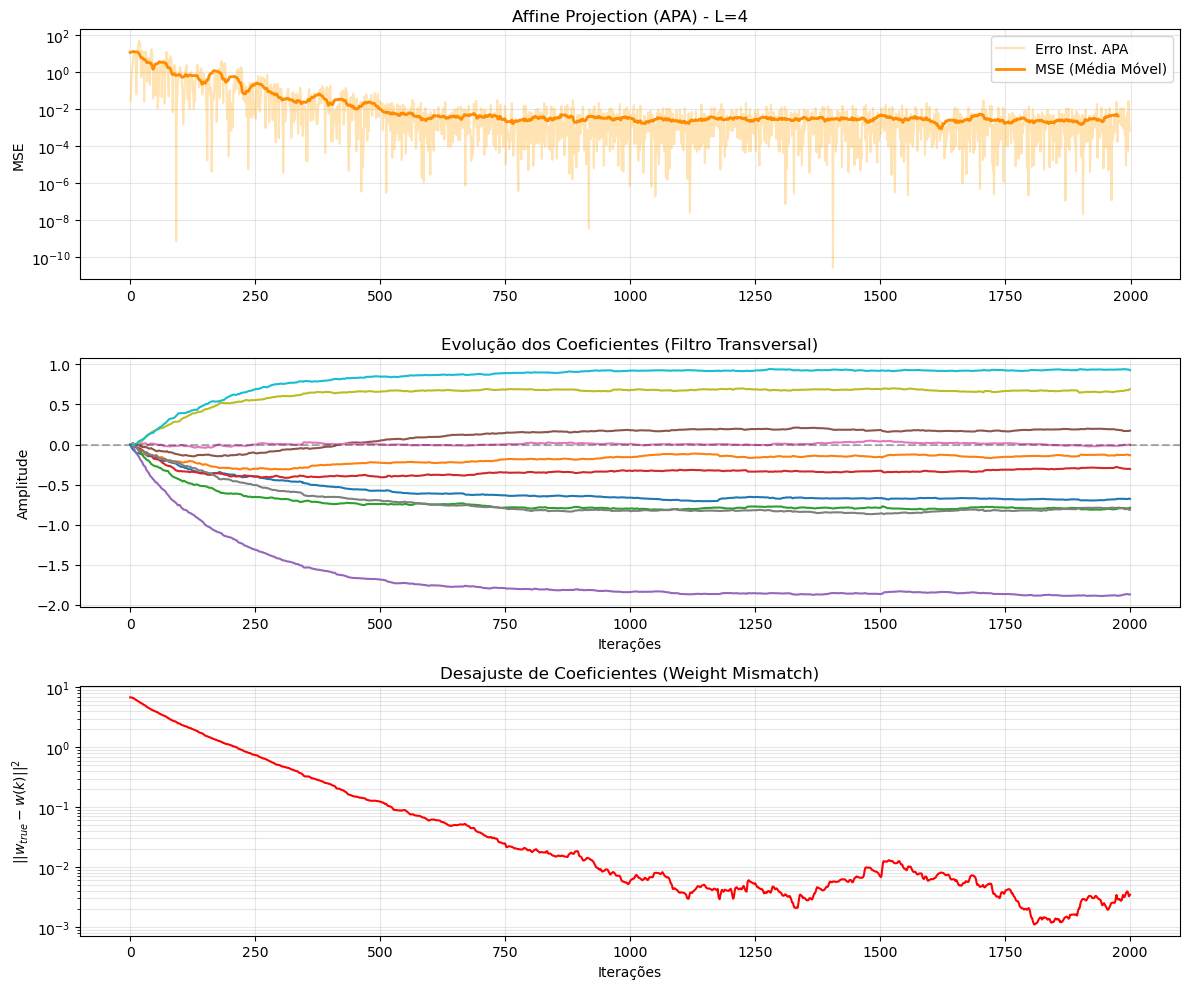

Norma do erro final de coeficientes: 0.003432


In [4]:
# --- 3. ANÁLISE VISUAL ---
plt.figure(figsize=(12, 10))

# Subplot 1: Erro Quadrático
plt.subplot(3, 1, 1)
plt.semilogy(result.mse(), label='Erro Inst. APA', alpha=0.3, color='orange')
plt.semilogy(np.convolve(result.mse(), np.ones(25)/25, mode='valid'), 
             label='MSE (Média Móvel)', color='darkorange', lw=2)
plt.title(f'Affine Projection (APA) - L={L_projection}')
plt.ylabel('MSE')
plt.grid(True, which='both', alpha=0.3)
plt.legend()

# Subplot 2: Trajetória dos Coeficientes
plt.subplot(3, 1, 2)
coeffs = np.real(result.coefficients)
plt.plot(coeffs)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)
plt.title('Evolução dos Coeficientes (Filtro Transversal)')
plt.ylabel('Amplitude')
plt.xlabel('Iterações')
plt.grid(True, alpha=0.3)

# Subplot 3: Erro de Desajuste (Mismatch)
plt.subplot(3, 1, 3)
# Calculando a norma da diferença entre w_estimado e w_real
mismatch = np.linalg.norm(result.coefficients - w_true, axis=1)**2
plt.semilogy(mismatch, color='red')
plt.title('Desajuste de Coeficientes (Weight Mismatch)')
plt.ylabel('$||w_{true} - w(k)||^2$')
plt.xlabel('Iterações')
plt.grid(True, which='both', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Norma do erro final de coeficientes: {mismatch[-1]:.6f}")